In [6]:
import os
import sys
import time
import random
import numpy as np
from tqdm import tqdm
import nibabel as nib
from PIL import Image
import tensorflow as tf
from skimage.io import imread
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import  img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.metrics import Recall, Precision
from TV_UNET import get_unet, TV_bin_loss

(512, 512, 100)
No. of test image =  9


100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


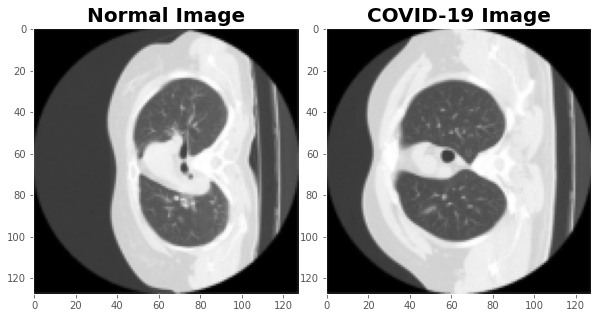

In [29]:
path = ''
im_width = 128
im_height = 128
num_class = 2

########## Load dataset 1
train1 = nib.load(path+'CT_seg1/tr_im.nii.gz')

train_np1 = np.array(train1.get_fdata())

[x,y,z] = train_np1.shape

print(train_np1.shape)

train = np.full((z,x,y),0)

for i in range(z):
    train[i,:,:] = train_np1[:,:,i]

mask1 = nib.load(path+'CT_seg1/tr_mask.nii.gz')
mask_np1 = np.array(mask1.get_fdata())

[x,y,z] = mask_np1.shape
mask = np.full((z,x,y),0)

for i in range(z):
    mask[i,:,:] = mask_np1[:,:,i]
  
########## Load dataset 2
ids1 = next(os.walk(path+'CT_seg2/rp_im/'))[2] # list of Masks

print("No. of test image = ", len(ids1))

sys.stdout.flush()

id_train = ids1[0:6]
id_test = ids1[6:]

for n, id_ in tqdm(enumerate(id_train), total=len(id_train)):
    train2 = nib.load(path + 'CT_seg2/rp_im/'+id_)
    train_np2 = np.array(train2.get_fdata())
    mask2 = nib.load(path + 'CT_seg2/rp_msk/'+id_)
    mask_np2 = np.array(mask2.get_fdata())

    [x,y,z] = train_np2.shape
    train_np2 = resize(train_np2, (512, 512, z), mode = 'constant', preserve_range = True)
    mask_np2 = resize(mask_np2, (512, 512, z), mode = 'constant', preserve_range = True)

    X_train = np.full((z, 512, 512),0)
    X_mask = np.full((z, 512, 512),0)

    for i in range(z):
        X_train[i,:,:] = train_np2[:,:,i]
        X_mask[i,:,:] = mask_np2[:,:,i]

    train = np.vstack((train, X_train))
    mask = np.vstack((mask, X_mask))

'''#########################################################################'''
########## Resize data and Label
labels = np.full((len(mask), 128, 128, num_class), 0)

X = np.full((len(train), 128, 128, 1), 0)

for i in range(len(mask)):
    X[i,:,:,0] = resize(train[i,:,:], (128, 128), mode = 'constant', preserve_range = True, anti_aliasing=True)
    m1 = resize(mask[i,:,:], (128, 128), mode = 'constant', preserve_range = True, anti_aliasing=False)

    for ix in range(0, num_class):
        labels[i,:,:,ix] = np.where(m1==ix,1,0)

'''#########################################################################'''
########## Imshow normal and COVID-19 images
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(X[128, ..., 0], cmap='gray')
ax[0].set_title('Normal Image', fontweight = "bold", size=20)

ax[1].imshow(X[171, ..., 0], cmap='gray')
ax[1].set_title('COVID-19 Image', fontweight = "bold", size=20)

plt.rcParams["axes.grid"] = False
plt.subplots_adjust(wspace=0.1, hspace=-0.65)

plt.savefig("Normal_Covid.png")

######################

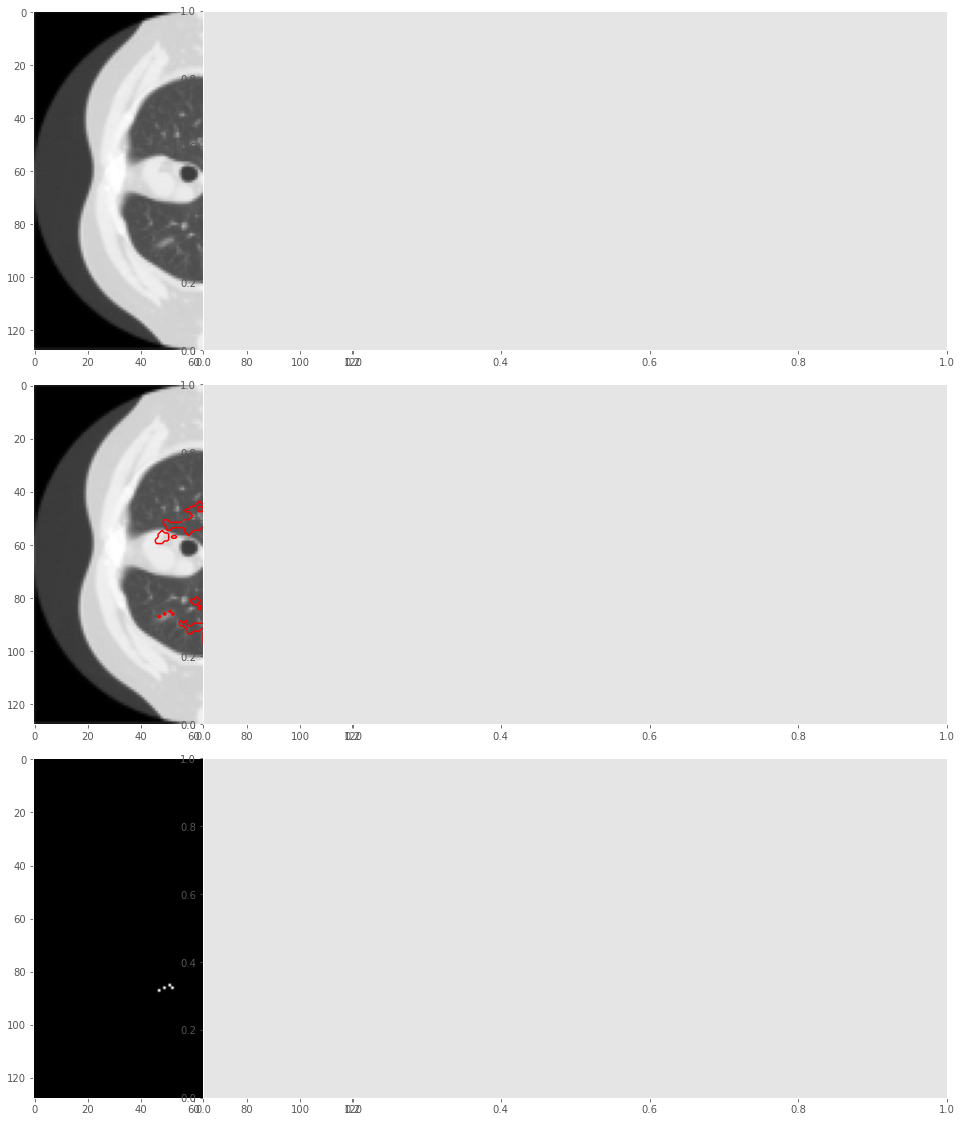

In [30]:
i = 0
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
for j in [3, 171]:
    m1 = resize(labels[j, :, : ,1], (128, 128), mode = 'constant', preserve_range = True, anti_aliasing = False)
    ax[0, i].imshow(X[j, ..., 0], cmap = 'gray')
    ax[1, i].imshow(X[j, ..., 0], cmap = 'gray')
    ax[1, i].contour(m1.squeeze(), colors = 'r', levels=[0.5])
    ax[2, i].imshow(m1, cmap='gray')

    plt.rcParams["axes.grid"] = False
    plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    #plt.subplots_adjust(wspace=0.5, hspace=0.1)
    
plt.savefig("Normal_covid_contours.png")

(360, 128, 128, 1) (360, 128, 128, 2) (40, 128, 128, 1) (40, 128, 128, 2)
Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.8736 - dice_loss: 0.3145 - recall_1: 0.9325 - pre_1: 0.7529
Epoch 00001: val_loss improved from inf to 7.80471, saving model to model-TV-UNet2.h5
12/12 [==============================] - 15s 717ms/step - loss: 0.4770 - accuracy: 0.8736 - dice_loss: 0.3145 - recall_1: 0.9325 - pre_1: 0.7529 - val_loss: 7.8047 - val_accuracy: 0.9550 - val_dice_loss: 0.3471 - val_recall_1: 0.9680 - val_pre_1: 0.4907 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9819 - dice_loss: 0.1697 - recall_1: 0.9844 - pre_1: 0.9675
Epoch 00002: val_loss improved from 7.80471 to 6.70127, saving model to model-TV-UNet2.h5
12/12 [==============================] - 7s 629ms/step - loss: 0.2052 - accuracy: 0.9819 - dice_loss: 0.1697 - recall_1: 0.9844 - pre_1: 0.9675 - val_loss: 6.7013 - val_accuracy: 0.78

100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


17/17 [==============================] - 3s 157ms/step


'#########################################################################'

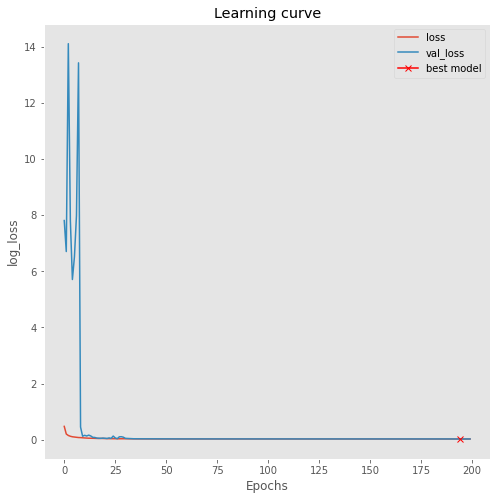

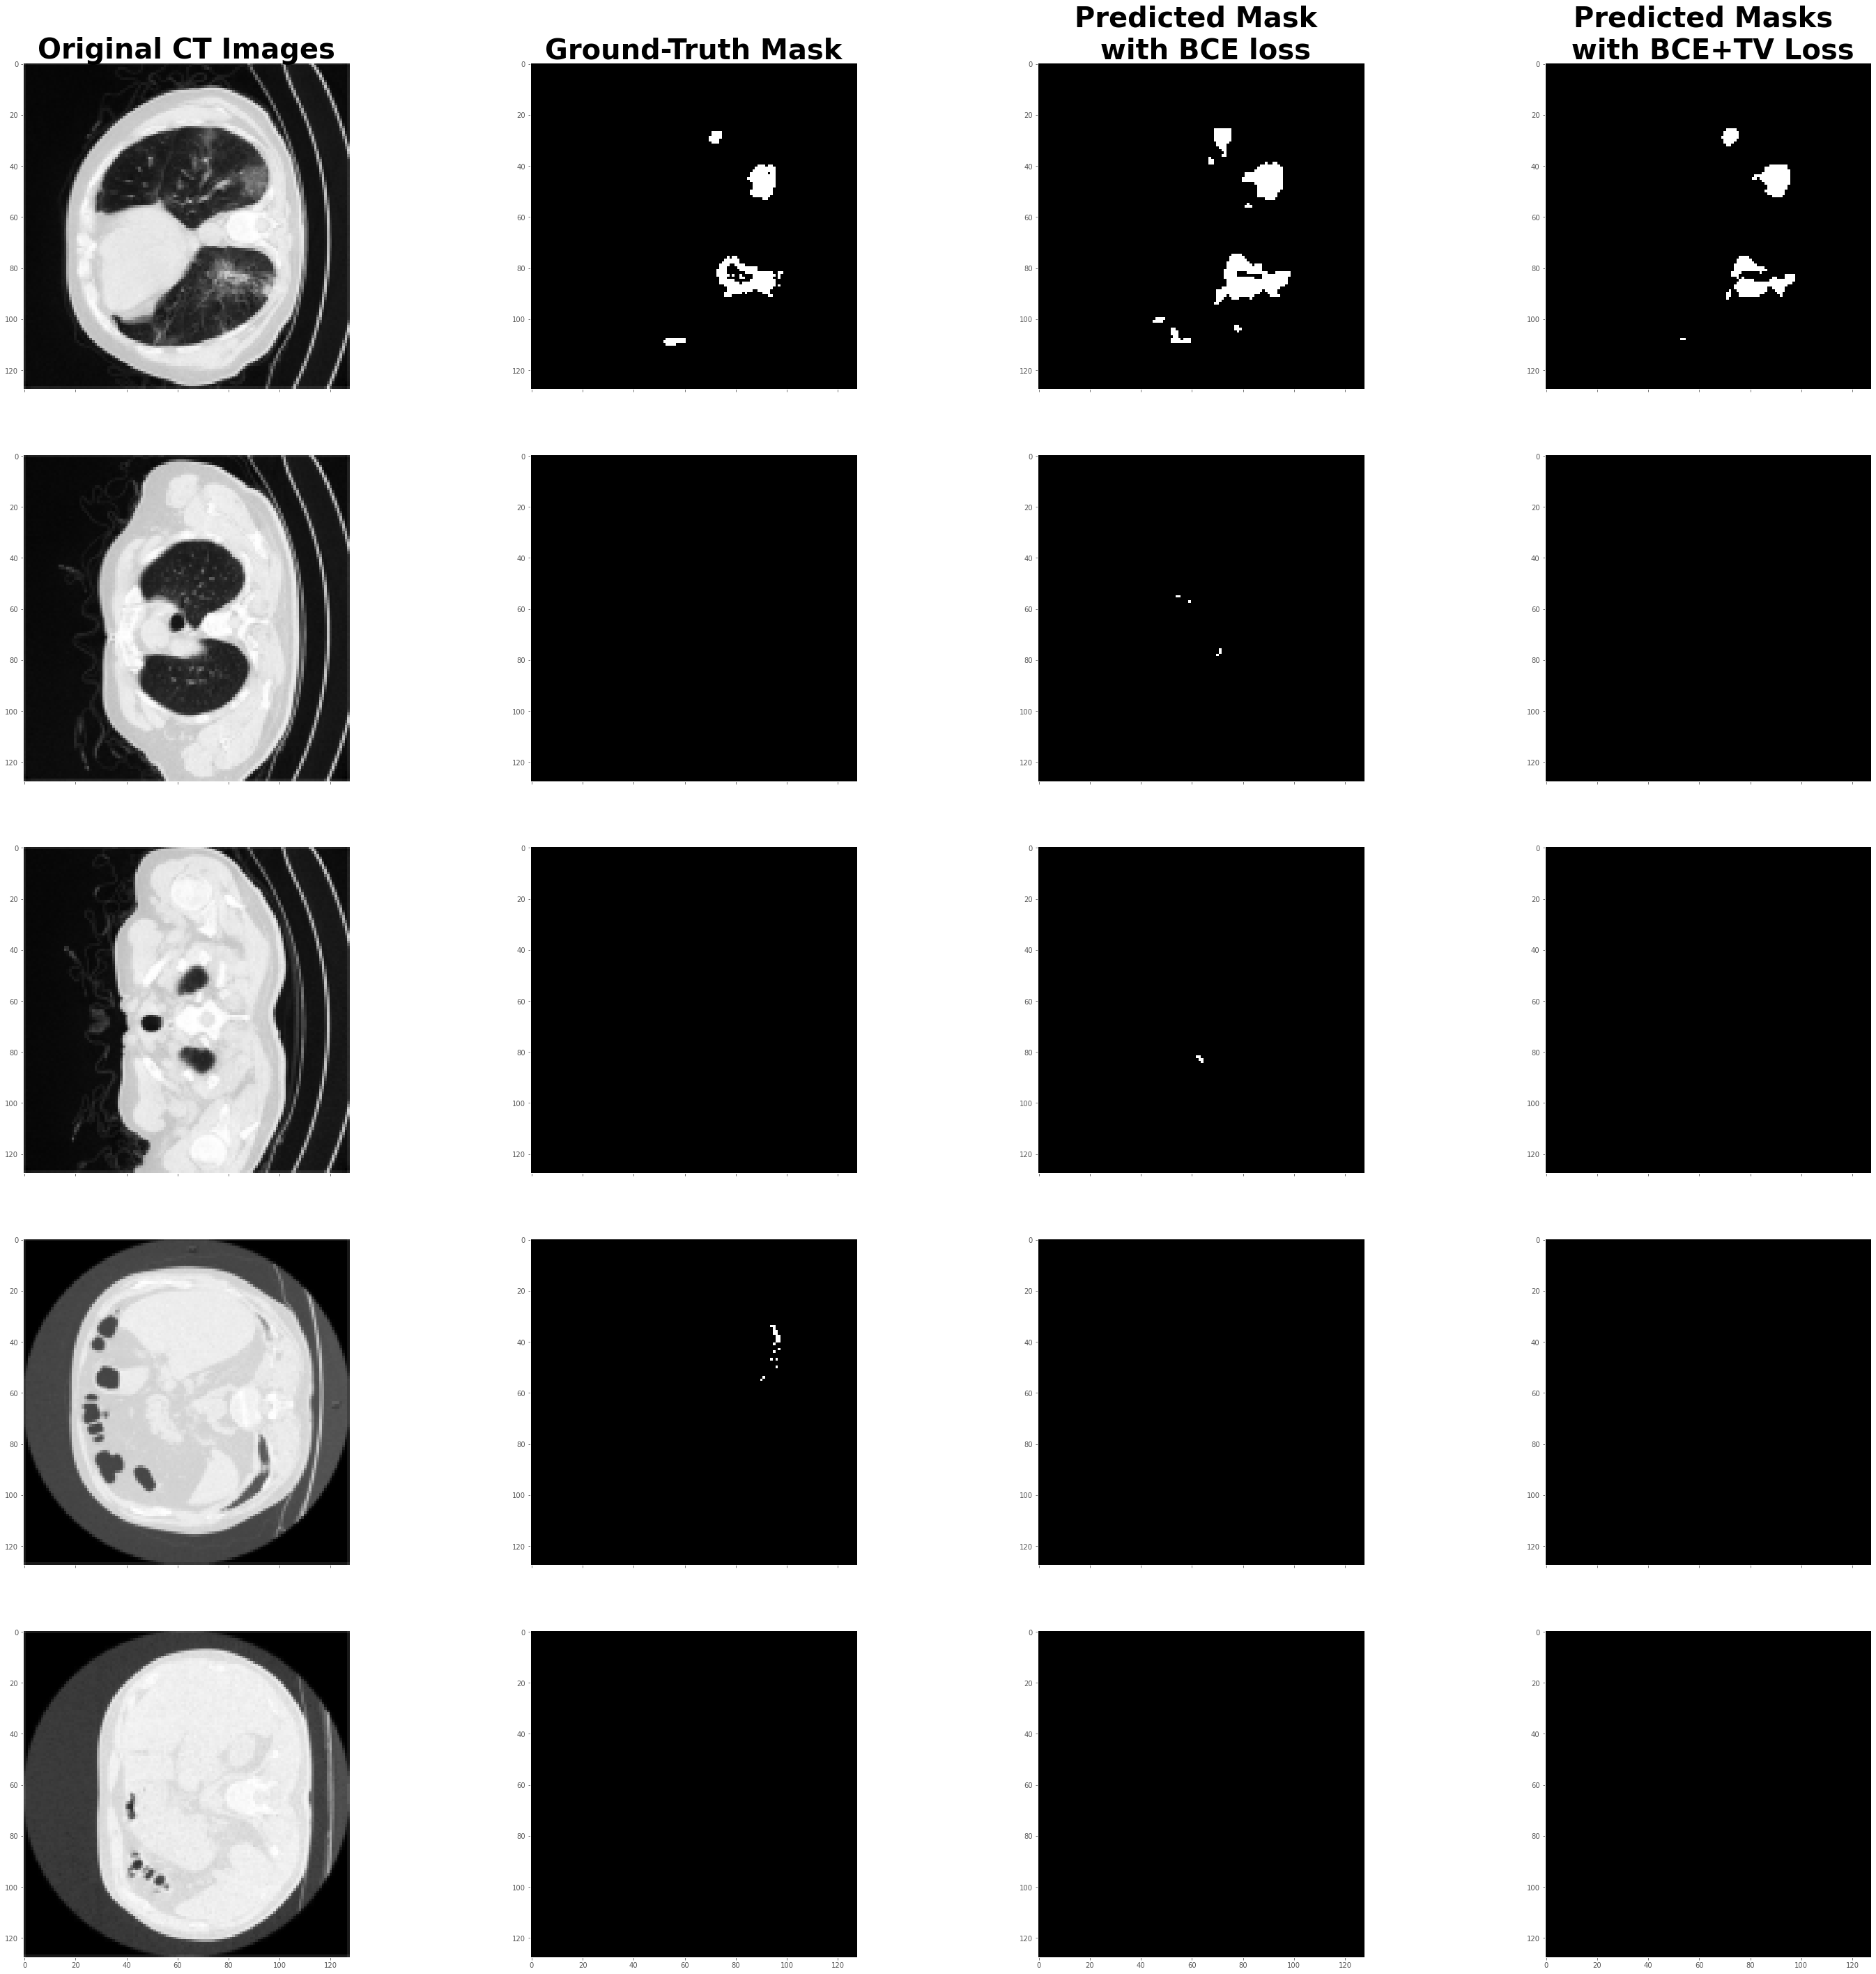

In [32]:
'''#########################################################################'''
'''#########################################################################'''
########## Applying TV_UNET Model
def dice_coef(y_pred, y_true):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

input_img = Input((im_height, im_width,1), name = 'img')

model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)


def my_loss(y_true, y_pred):
  layer_names =[layer.name for layer in model.layers]
  for l in layer_names:
    if l==layer_names[-1]:
      value = TV_bin_loss(y_true, y_pred)
    else:
      value = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
  return value
  

model.compile(optimizer=Adam(), loss = [my_loss], metrics=['accuracy',dice_loss,Recall(name='recall_1'), Precision(name='pre_1')])
#model.summary()

'''#########################################################################'''
# Split train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.1, random_state=42)

callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-TV-UNet2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

#sys.exit()

results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,validation_data=(X_valid, y_valid))

model.save_weights("model-TV-UNet2.h5")
    
'''#########################################################################'''
########## Plot loss function
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

'''#########################################################################'''
'''#########################################################################'''
'''test'''
# ids1 = next(os.walk(path+'CT_seg2/rp_im_test/'))[2] # list of Masks

sys.stdout.flush()

test = np.full((1,128,128,1),0)

mask_test = np.full((1,128,128),0)

for n, id_ in tqdm(enumerate(id_test), total=len(id_test)): 
  test2 = nib.load(path+'CT_seg2/rp_im/'+id_)
  test_np2 = np.array(test2.get_fdata())
  mask_test2 = nib.load(path+'CT_seg2/rp_msk/'+id_)
  mask_test_np2 = np.array(mask_test2.get_fdata())

  [x,y,z] = test_np2.shape
  test_np2 = resize(test_np2, (im_height, im_height, z), mode = 'constant', preserve_range = True)
  mask_np2 = resize(mask_test_np2, (im_height, im_height, z), mode = 'constant', preserve_range = True,
                   anti_aliasing=False)

  X_test = np.full((z,im_height,im_height,1),0)
  y_test = np.full((z,im_height,im_height),0)
  
  for i in range(z):
    X_test[i,:,:,0] = test_np2[:,:,i]
    y_test[i,:,:] = mask_np2[:,:,i]

  test = np.vstack((test,X_test))
  mask_test = np.vstack((mask_test,y_test))
  
'''#########################################################################'''
import numpy as np
label_test = np.full((len(mask_test),128,128,num_class),0)

for i in range(len(mask_test)):
  m1 = mask_test[i,:,:]
  
  for ix in range(0,num_class):
    label_test[i,:,:,ix] = np.where(m1==ix,1,0)
    
'''#########################################################################'''
########## Load the best Models and plot results
#model.load_weights('weight-UNet.h5')

'''#########################################################################'''

(530, 128, 128, 1)
17/17 [==============================] - 2s 144ms/step
[ 24 352  60 198 369]


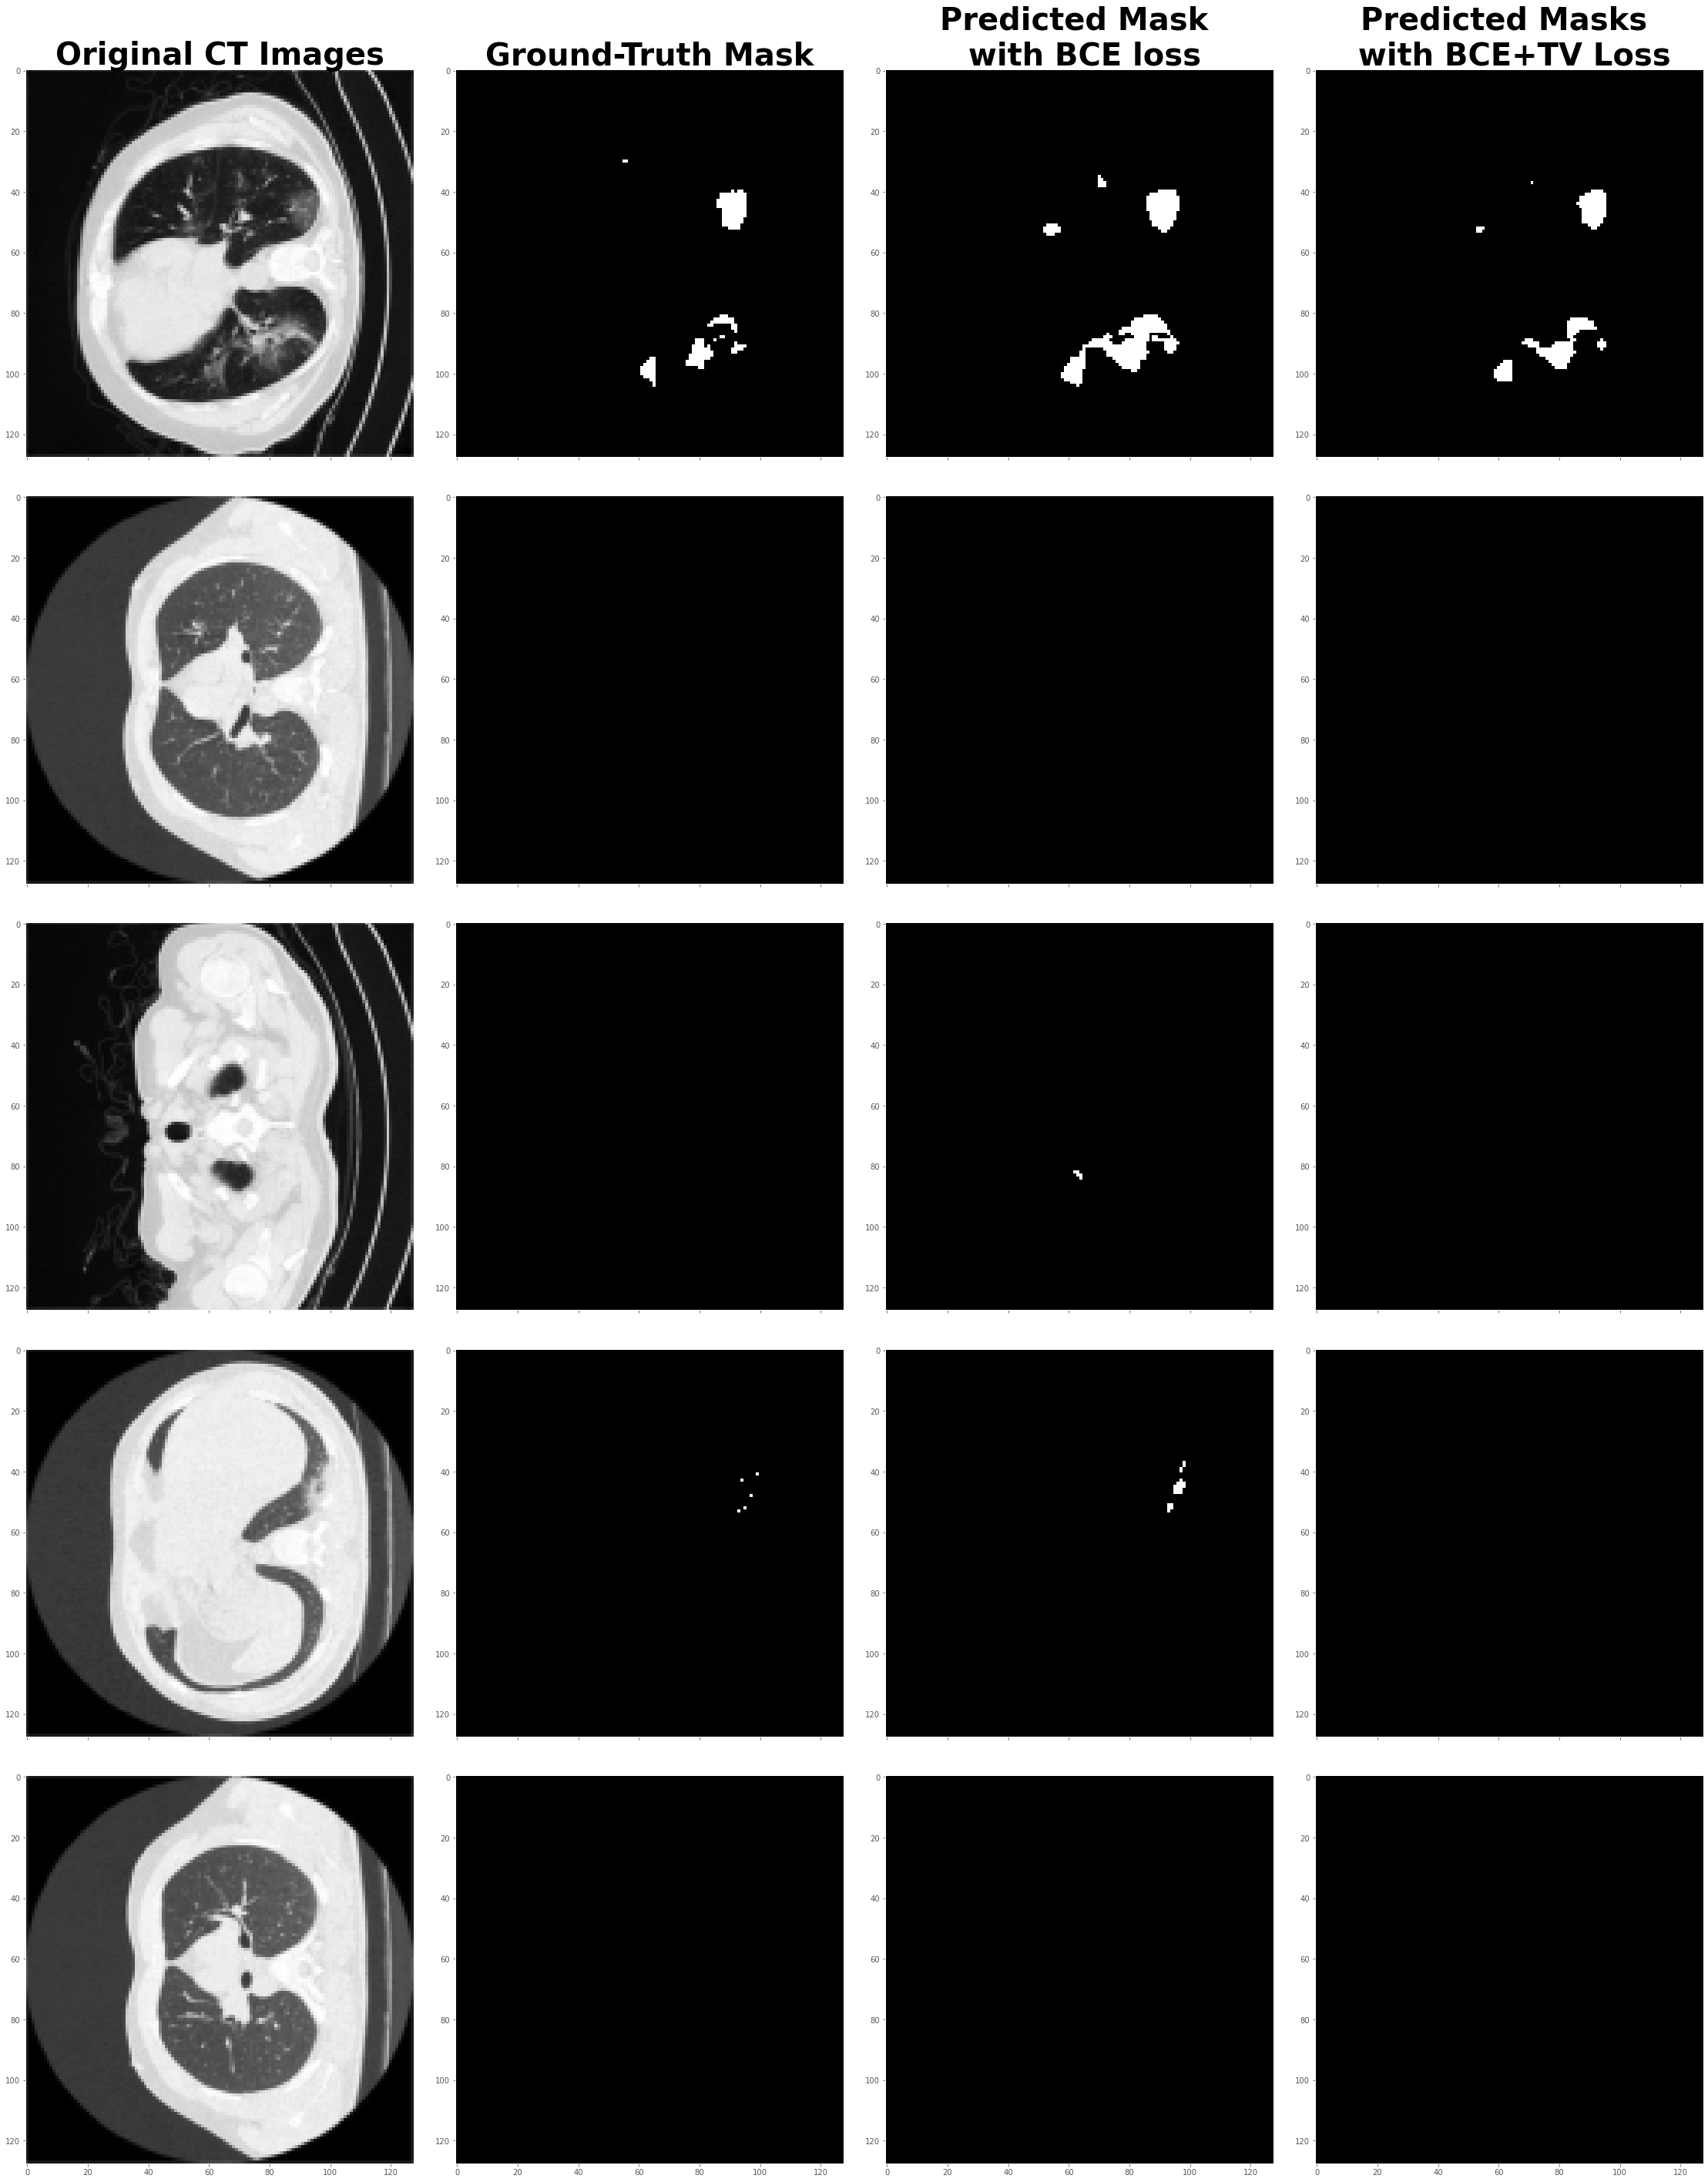

In [40]:
# predict
print(test.shape)
loaded_model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)
loaded_model.load_weights("model-TV-UNet2.h5")
preds_test1 = loaded_model.predict(test, verbose=1)
preds_test_t1 = (preds_test1 > 0.1).astype(np.uint8)

#model.load_weights('weight-TV-UNet.h5')
preds_test2 = loaded_model.predict(test, verbose=1)
preds_test_t2 = (preds_test2 > 0.3).astype(np.uint8)

no_pred = 5
rand_indx = np.random.randint(1, test.shape[0], no_pred)
print(rand_indx)
def plot_sample(X, y, binary_preds1, binary_preds2):
    fig, axs = plt.subplots(5, 4, figsize=(50, 50),sharex='all')
    i = 0

    for ix in rand_indx:
      l = 1

      axs[i,0].imshow(X[ix, ..., 0], cmap='gray')
      axs[0,0].set_title('Original CT Images',fontweight="bold", size=40)

      axs[i,1].imshow(y[ix,:,:,l].squeeze(),cmap='gray')
      axs[0,1].set_title('Ground-Truth Mask',fontweight="bold", size=40)

      axs[i,2].imshow(binary_preds1[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,2].set_title('Predicted Mask \n with BCE loss',fontweight="bold", size=40)
      
      axs[i,3].imshow(binary_preds2[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,3].set_title('Predicted Masks \n with BCE+TV Loss',fontweight="bold", size=40);
      
      i += 1
      
      plt.rcParams["axes.grid"] = False
      plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    plt.savefig("true_pred.png")

plot_sample(test, label_test, preds_test_t1, preds_test_t2)
plt.rcParams["axes.grid"] = False

/data/jwd/main/040/914/40914875/tmp/ipykernel_1095/956160351.py:66: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('Average-Precision for Unet Model ({0:0.2f})'.format(average_precision1['micro']),
/data/jwd/main/040/914/40914875/tmp/ipykernel_1095/956160351.py:66: UserWarning: Legend does not support 'v' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('Average-Precision for Unet Model ({0:0.2f})'.format(average_precision1['micro']),
/data/jwd/main/040/914/40914875/tmp/ipykernel_1095/956160351.py:66: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-addi

recall_unet= [0.83344024 0.7437707  0.6738317  0.6096674  0.5467864  0.47064486
 0.3727409  0.21880013 0.0165223 ]
precision_unet= [0.4210768  0.5023656  0.5525981  0.59382325 0.63772994 0.68738776
 0.74025697 0.78136337 0.9307229 ]


ValueError: Shapes (8683520,) and (5898240,) are incompatible

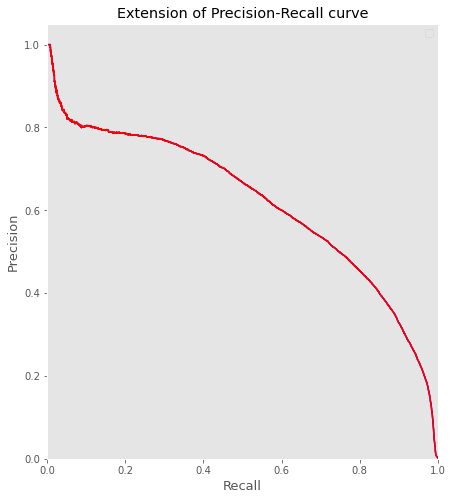

In [8]:
'''#########################################################################'''
########## plot Pre_Recall curve
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import average_precision_score

labels = []

########## For Unet Model
precision1 = dict()
recall1 = dict()
average_precision1 = dict()

for i in range(num_class):
  y_test_f=K.flatten(label_test[:,:,:,i])
  preds_test_f=K.flatten(preds_test1[:,:,:,i])
  precision1[i], recall1[i], _ = precision_recall_curve(y_test_f,preds_test_f)
                                                       
  average_precision1[i] = average_precision_score(y_test_f,preds_test_f)
  
##################################################
# A "micro-average": quantifying score on all classes jointly
y_test_f=K.flatten(label_test[:,:,:,1])
preds_test_f=K.flatten(preds_test1[:,:,:,1])
precision1["micro"], recall1["micro"], _ = precision_recall_curve(y_test_f,preds_test_f)
average_precision1["micro"] = average_precision_score(y_test_f,preds_test_f,
                                                     average="micro")

########## For TV_Unet Model
precision2 = dict()
recall2 = dict()
average_precision2 = dict()

for i in range(num_class):
  y_test_f=K.flatten(label_test[:,:,:,i])
  preds_test_f=K.flatten(preds_test2[:,:,:,i])
  precision2[i], recall2[i], _ = precision_recall_curve(y_test_f,preds_test_f)
                                                       
  average_precision2[i] = average_precision_score(y_test_f,preds_test_f)
  
##################################################
# A "micro-average": quantifying score on all classes jointly
y_test_f=K.flatten(label_test[:,:,:,1])
preds_test_f=K.flatten(preds_test2[:,:,:,1])
precision2["micro"], recall2["micro"], _ = precision_recall_curve(y_test_f,preds_test_f)
average_precision2["micro"] = average_precision_score(y_test_f,preds_test_f,
                                                     average="micro")

##################################################


plt.figure(figsize=(7, 8))
plt.step(recall1['micro'], precision1['micro'], where='post', color='b', 
         label='Average-Precision for Unet Model ({0:0.2f})'.format(average_precision1['micro']))

plt.step(recall2['micro'], precision2['micro'], where='post', color='r',
         label='Average-Precision for TV-Unet Model ({0:0.2f})'.format(average_precision2['micro']))


plt.xlabel('Recall', size=13)
plt.ylabel('Precision', size=13)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Extension of Precision-Recall curve')
plt.legend('Average-Precision for Unet Model ({0:0.2f})'.format(average_precision1['micro']),
           'Average-Precision for TV-Unet Model ({0:0.2f})'.format(average_precision2['micro']))

'''#########################################################################'''
########## calculate precision and recall for each Model
tre=np.arange(0.1,1,0.1).tolist()

y_test_f=K.flatten(label_test[:,:,:,1])
preds_test_f=K.flatten(preds_test1[:,:,:,1])
m = tf.keras.metrics.Recall(thresholds=tre)
n = tf.keras.metrics.Precision(thresholds=tre)
m.update_state(y_test_f, preds_test_f)
n.update_state(y_test_f, preds_test_f)
recal_unet=m.result().numpy()
pre_unet=n.result().numpy()
print('recall_unet=',recal_unet)
print('precision_unet=',pre_unet)

m.reset_states()
n.reset_states()
y_test_f=K.flatten(y_train[:,:,:,1])
preds_test_f=K.flatten(preds_test2[:,:,:,1])
m = tf.keras.metrics.Recall(thresholds=tre)
n = tf.keras.metrics.Precision(thresholds=tre)
m.update_state(y_test_f, preds_test_f)
n.update_state(y_test_f, preds_test_f)
recal_TVUnet=m.result().numpy()
pre_TVUnet=n.result().numpy()
print('recall_TV Unet=',recal_TVUnet)
print('precision_TV Unet=',pre_TVUnet)

'''#########################################################################'''
########## calculate dice score for each model
def dice_coef(y_pred, y_true):
  for tr in np.arange(0.1,1,0.1):
    y_pred_t = (y_pred[:,:,:,1] > tr).astype(np.uint8)
    y_true_f = np.array(y_true[:,:,:,1])
    y_pred_f = np.array(y_pred_t)
    intersection = np.sum(y_true_f * y_pred_f)
    print( 2*(intersection) / (np.sum(y_true_f) + np.sum(y_pred_f)))

dice=dice_coef(preds_test1,label_test)
print('Unet DSC=', dice)

dice=dice_coef(preds_test2,label_test)
print('TV Unet DSC=', dice)

'''#########################################################################'''
########## calculate mIOU
def jaccard_distance_loss(y_true, y_pred, smooth=100):
  for tr in np.arange(0.1,1,0.1):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    """
    y_pred_t = (y_pred[:,:,:,:] > tr).astype(np.uint8)
    y_true_f = np.array(y_true[:,:,:,:])
    y_pred_f = np.array(y_pred_t)
    intersection = np.sum(y_true_f * y_pred_f,axis=-1)
    sum_ = np.sum(np.abs(y_true_f) + np.abs(y_pred_f),axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    print(np.mean(jac))

mIOU=jaccard_distance_loss(label_test, preds_test1)
print('Unet mIOU=', mIOU)

mIOU=jaccard_distance_loss(label_test, preds_test2)
print('Unet mIOU=', mIOU)
